In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import random

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
def plot_SI(si):
    si = torch.tensor(si._stats).t()
    plt.plot(si[0].numpy(),label="S")
    plt.plot(si[1].numpy(),label="I")
    plt.legend()

In [3]:
class SI_erdos_renyi:
    def __init__(self,n,seed=[0],m=None,pinf=0.1):
        if m is None: 
            m=3*n
        self._S = torch.ones((1,n),device=device) 
        self._I = torch.zeros((1,n),device=device)
        self._S[0,seed]=0
        self._I[0,seed]=1
        
        idx = torch.randint(n,(2,m))
        self._con = torch.sparse.FloatTensor(idx,torch.ones(m),torch.Size([n,n])).to(device)
        self._pinfs = torch.ones((n,1), device=device)*pinf
        self._n = n
        
        self._i = 0
        self._stats = []

            
    def step(self):  
        dI = self._con.mm(self._I.t())
        dI = dI*self._pinfs
        dI = torch.rand(self._n,device=device)<dI.t()
        dI = dI.float()
        self._I = torch.max(self._I,dI)
        self._S -= dI
        self._S = F.relu(self._S)
        self._i+=1
        self._stats.append((self._S.sum(),self._I.sum()))
        
        return self._stats[self._i-1]
    
    def get_pinfs(self):
        return self._pinfs
    
    def set_pinfs(self, pinfs):
        self._pinfs = pinfs
        
    def get_I(self):
        return self._I
    
    def get_S(self):
        return self._S

In [4]:
#the probability of infected from low to high (0.1 - 0.5)
Ss_bio = []
Is_bio = []
Ss_soc = []
Is_soc = []

pinf_bio = 0 # probability of disease spreading from person to person
pinf_soc = 0 # probability of anti-mask ideas spreading
pinf_nomask = 0 # probability of getting infected by a person not wearing a mask is higher
pinf_infected = 0 # lower probability of spreading anti-mask messages if person is infected

maxt = 30
#number of total people
n=200
mult_bio = 2
mult_soc = 0.5

for i in range(5):
    pinf_bio=0.1*i
    pinf_nomask = mult_bio*pinf_bio
    for j in range(5):
        pinf_soc = 0.1*j
        pinf_infected = mult_soc*pinf_soc
        with torch.no_grad():
            # different seeds each SI model since unlikely that only anti-masker is the one to get infected first
            si_bio = SI_erdos_renyi(n,seed=[random.randint(0,n-1)],m=15*n,pinf=pinf_bio)
            si_soc = SI_erdos_renyi(n,seed=[random.randint(0,n-1)],m=15*n,pinf=pinf_soc) 
            for _ in range(maxt): 
                si_bio.step()
                si_soc.step()
                # anti maskers have higher probability of infecting others
                si_bio.set_pinfs(torch.max(si_bio.get_pinfs(), si_soc.get_I().t()*pinf_nomask)) 
                si_soc.set_pinfs(torch.abs(torch.min(-si_soc.get_pinfs(), -si_bio.get_I().t()*pinf_infected)))
        si_bio = torch.tensor(si_bio._stats).t()
        Ss_bio.append(si_bio[0].numpy())#will be plot
        Is_bio.append(si_bio[1].numpy())#will be plot
        si_soc = torch.tensor(si_soc._stats).t()
        Ss_soc.append(si_soc[0].numpy())
        Is_soc.append(si_soc[1].numpy())

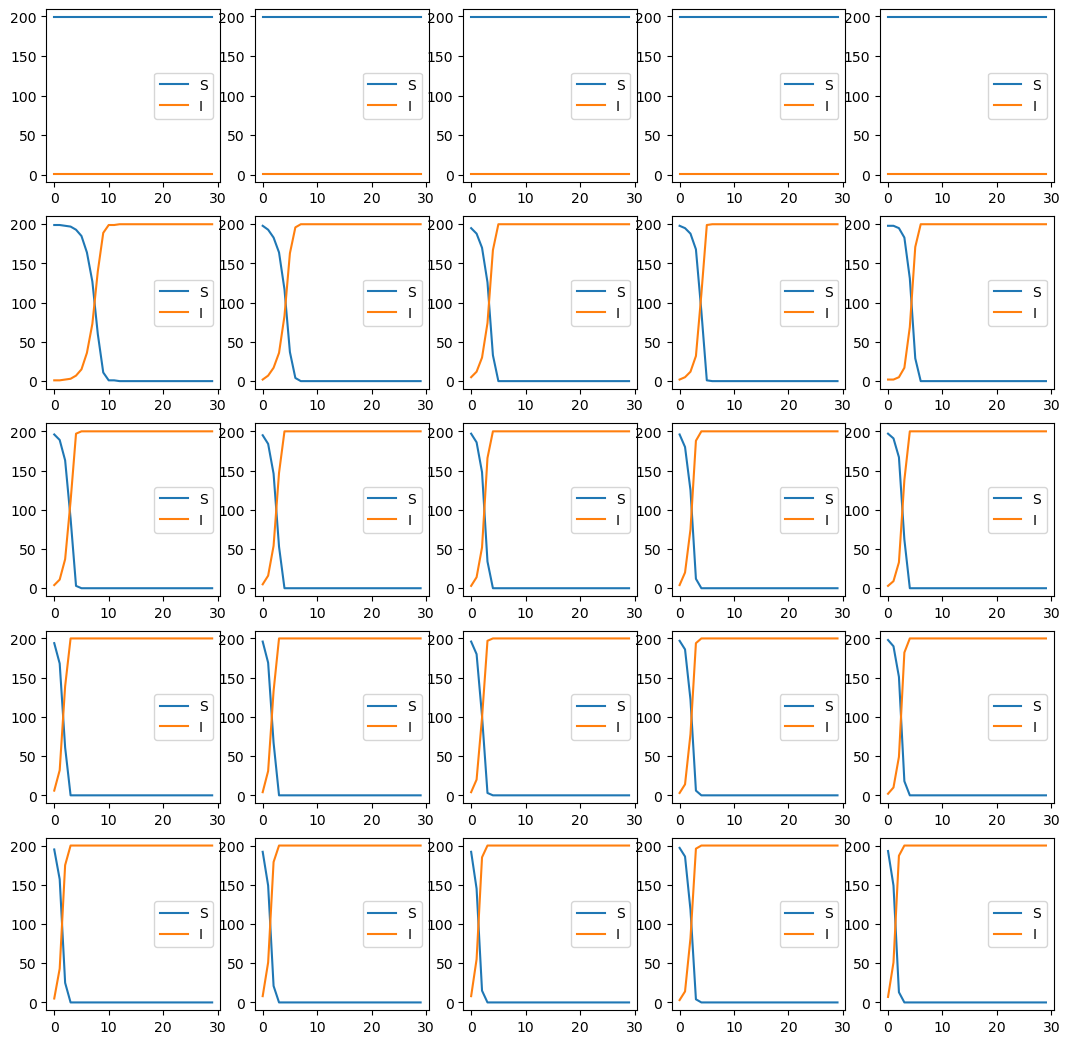

In [5]:
# bio plots
# pinf_bio increasing downward and pinf_soc increasing to the right
# pinf_nomask is constant multiple of pinf_bio and pinf_infected is constant multiple of pinf_soc
figure, axis = plt.subplots(5, 5)
figure.set_size_inches(13, 13)
for i in range(5):
    for j in range(5):
        axis[i,j].plot(Ss_bio[i*5+j], label="S")
        axis[i,j].plot(Is_bio[i*5+j], label="I")
        axis[i,j].legend()

In [198]:
Ss_bio = []
Is_bio = []
Ss_soc = []
Is_soc = []

pinf_bio = 0.1 # probability of disease spreading from person to person
pinf_soc = 0.1 # probability of anti-mask ideas spreading
pinf_nomask = 0 # probability of getting infected by a person not wearing a mask is higher
pinf_infected = 0 # lower probability of spreading anti-mask messages if person is infected
maxt = 30
n=200
mult_bio = 2
mult_soc = 0.5

for i in range(5):
    pinf_nomask = mult_bio*(1+0.5*i)*pinf_bio
    for j in range(5):
        pinf_infected = mult_soc*(1+0.5*j)*pinf_soc
        with torch.no_grad():
            # different seeds each SI model since unlikely that only anti-masker is the one to get infected first
            si_bio = SI_erdos_renyi(n,seed=[random.randint(0,n-1)],m=15*n,pinf=pinf_bio)
            si_soc = SI_erdos_renyi(n,seed=[random.randint(0,n-1)],m=15*n,pinf=pinf_soc) 
            for _ in range(maxt): 
                si_bio.step()
                si_soc.step()
                # anti maskers have higher probability of infecting others
                si_bio.set_pinfs(torch.max(si_bio.get_pinfs(), si_soc.get_I().t()*pinf_nomask)) 
                si_soc.set_pinfs(torch.abs(torch.min(-si_soc.get_pinfs(), -si_bio.get_I().t()*pinf_infected)))
        si_bio = torch.tensor(si_bio._stats).t()
        Ss_bio.append(si_bio[0].numpy())
        Is_bio.append(si_bio[1].numpy())
        si_soc = torch.tensor(si_soc._stats).t()
        Ss_soc.append(si_soc[0].numpy())
        Is_soc.append(si_soc[1].numpy())

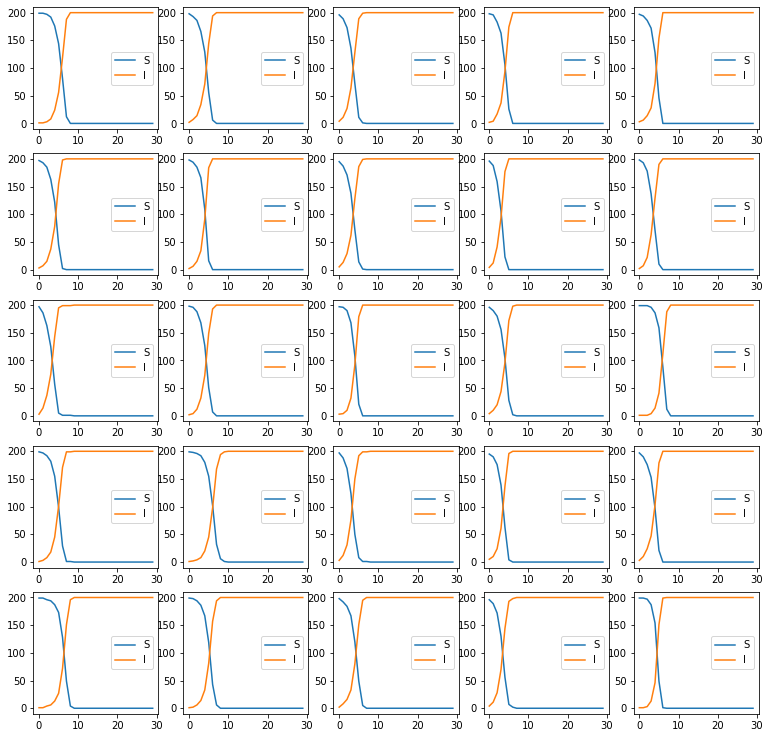

In [199]:
# bio plots
# pinf_nomask increasing downward and pinf_infected increasing to the right
figure, axis = plt.subplots(5, 5)
figure.set_size_inches(13, 13)
for i in range(5):
    for j in range(5):
        axis[i,j].plot(Ss_bio[i*5+j], label="S")
        axis[i,j].plot(Is_bio[i*5+j], label="I")
        axis[i,j].legend()